In [1]:
from __future__ import print_function, division

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime

import tensorflow as tf

from glob import glob
import os, sys

%matplotlib inline

##### Some setup data...

In [2]:
team_long_names = [k.strip() for k in """Atlanta Hawks
                    New Jersey Nets
                    Brooklyn Nets
                    Boston Celtics
                    Charlotte Hornets
                    Chicago Bulls
                    Cleveland Cavaliers
                    Dallas Mavericks
                    Denver Nuggets
                    Detroit Pistons
                    Golden State Warriors
                    Houston Rockets
                    Indiana Pacers
                    Los Angeles Clippers
                    Los Angeles Lakers
                    Memphis Grizzlies
                    Miami Heat
                    Milwaukee Bucks
                    Minnesota Timberwolves
                    New Orleans Pelicans
                    New York Knicks
                    Oklahoma City Thunder
                    Orlando Magic
                    Philadelphia 76ers
                    Phoenix Suns
                    Portland Trail Blazers
                    Sacramento Kings
                    San Antonio Spurs
                    Toronto Raptors
                    Utah Jazz
                    Washington Bullets
                    Washington Wizards
                    Seattle SuperSonics
                    Baltimore Bullets""".split('\n')]

team_short_names = [k.strip() for k in """ATL  
                    NJN  
                    BKN  
                    BOS  
                    CHA  
                    CHI  
                    CLE  
                    DAL  
                    DEN  
                    DET  
                    GSW  
                    HOU  
                    IND  
                    LAC  
                    LAL  
                    MEM  
                    MIA  
                    MIL  
                    MIN  
                    NOP  
                    NYK  
                    OKC  
                    ORL  
                    PHI  
                    PHX  
                    POR  
                    SAC  
                    SAS  
                    TOR  
                    UTA  
                    WAS 
                    WAS
                    SEA 
                    BAL""".split()]

long_to_short = dict(zip(team_long_names, team_short_names))
short_to_long = dict(zip(team_short_names, team_long_names))

In [3]:
## how do we weight stats when calculating a players value?  larger number = more weight
stat_weights = {'PTS': 2.0, 
                'AST': 1.5,
                'BLK': 1.25,
                'TRB': 1.0,
                'ORB': 0.5, 
                'STL': 1.25,
                'TOV': -2.0,
                'MissedShots':-0.5}
base_stat_keys = list(stat_weights.keys())

for k in base_stat_keys:
    stat_weights[k + '_PER36'] = stat_weights[k] * 1.25
    
stat_keys = stat_weights.keys()

champ_multiplier = 0.66
ru_multiplier = 0.33
finals_minutes_multiplier = 0.2
playoff_multipliers = lambda ii:  0.1*np.sqrt(int(ii))

mvp_value = 8
dpoy_value = 4
sixth_man_value = 2
finals_mvp_value = 4
all_star_value = 1.5
all_nba_values = {'1st':3, '2nd':2, '3rd':1}

In [4]:
column_renamer = {'Pos':'Position', 
                 'Tm':'Team', 
                 'G':'GamesPlayed', 
                 'GS':'GamesStarted',
                 'MP':'MinutesPlayed',
                 'PF':'Fouls',
                 'Starters':'Player'}

def parse_bball_ref_common_cols(df):
    df.rename(columns=column_renamer, inplace=True)
    df['PlayerName'] = df['Player'].apply(lambda x:  x.split('\\')[0].replace('*', ''))
    df['PlayerID'] = df['Player'].apply(lambda x:  x.split('\\')[1])
    
    df.drop(columns=[k for k in ['Player'] if k in df.keys()], inplace=True)
    return df

def add_additional_stats(df):
    df['MissedShots'] = df['FGA'] - df['FG']
    for key in base_stat_keys:
        df[key + '_PER36'] = 36.0 * df[key] / df['MinutesPlayed']
    return df

#### Read info about teams that made it to the finals, players that are in the HOF, MVP winners, players that made All-NBA and All-Star teams, DPOYs, and Sixth man awards

In [5]:
finals_team_data = pd.read_csv('finals_stats.csv', index_col='Year')
finals_team_data.dropna(axis='index', inplace=True)
finals_team_data['Champion'] = finals_team_data['Champion'].apply(lambda x: long_to_short[x])
finals_team_data['Runner-Up'] = finals_team_data['Runner-Up'].apply(lambda x: long_to_short[x])
finals_team_data.drop(columns=['Lg'], inplace=True)

In [6]:
hof = pd.read_table('hof_players.txt', delim_whitespace=True)
hof['Name'] = [fn + ' ' + ln for (fn, ln) in zip(hof['FirstName'], hof['LastName'])]
hof.drop(columns=['FirstName', 'LastName', 'Height(M)'], inplace=True)
hof_names = np.array(hof['Name'].values)

In [7]:
mvps = parse_bball_ref_common_cols(pd.read_csv('mvp_stats.csv'))
mvps['Year'] = mvps['Season'].apply(lambda x: int(x.split('-')[0]) + 1)
mvps.drop(columns=['Season','Team'], inplace=True)
mvps.set_index('Year', inplace=True)

In [8]:
dpoys = parse_bball_ref_common_cols(pd.read_csv('dpoy.csv'))
dpoys['Year'] = dpoys['Season'].apply(lambda x: int(x.split('-')[0]) + 1)
dpoys.drop(columns=['Season','Team'], inplace=True)
dpoys.set_index('Year', inplace=True)

In [9]:
sixth_man_winners = parse_bball_ref_common_cols(pd.read_csv('sixth_man.csv'))
sixth_man_winners['Year'] = sixth_man_winners['Season'].apply(lambda x: int(x.split('-')[0]) + 1)
sixth_man_winners.set_index('Year', inplace=True)
sixth_man_winners.drop(columns=['Lg', 'Voting', 'Season'], inplace=True)

In [10]:
all_star_pids = {1999:np.array([])}  ### no all-star game in 1999
all_star_files = sorted(glob('all_stars/*.csv'))
for fname in all_star_files:
    year = int(fname.split('/')[-1].split('.')[0])
    adf = parse_bball_ref_common_cols(pd.read_csv(fname))
    ## really don't care about any of the stats in the all-star game
    ## I just want to know if they made it or not
    all_star_pids[year] = adf['PlayerID'].values

In [11]:
all_nba_teams_by_year = {}
all_nba_teams = pd.read_csv('all_nba_teams.csv')
all_nba_teams['Year'] = all_nba_teams['Season'].apply(lambda x: int(x.split('-')[0]) + 1)
all_nba_teams.drop(columns=['Season', 'Lg'], inplace=True)
all_nba_teams.rename(columns={'Tm':'Team'}, inplace=True)
# all_nba_teams.set_index('Year', inplace=True)

all_nba_players_by_year = {}
for year in np.unique(all_nba_teams['Year']):
    teams_this_year = all_nba_teams.loc[all_nba_teams['Year'] == year]
    all_nba_players_by_year[year] = {}
    for idx, row in teams_this_year.iterrows():
        team = row['Team']
        these_players = []
        for val in row[1:-1]:
            if val.endswith(' C'):
                val = val[:-2]
            elif val.endswith(' F'):
                val = val[:-2]
            elif val.endswith(' G'):
                val = val[:-2]
            these_players.append(val)
        assert len(these_players) == 5        
        all_nba_players_by_year[year][team] = these_players

#### Read and parse playoff stats for reference later:

In [12]:
def read_and_clean_playoff_year(year):
    dataframes = {}
    for playoff_round in '1234':
        fname = 'playoff_player_stats/{}/round{}.csv'.format(year, playoff_round)
        df = read_and_clean_playoff_round_stats(fname)
        dataframes[playoff_round] = df
        if df.size:
            teams = np.count_nonzero(df['Rk']==1)
            expected_teams = 2**(5-int(playoff_round))
            if teams != expected_teams:
                print("Wrong number of teams for round {} in {}; have {}, expect {}".format(
                    playoff_round, year, teams, expected_teams))
    return dataframes

def read_and_clean_playoff_round_stats(fname):
    if not os.path.isfile(fname):
        print("No file for {}".format(fname))
        return pd.DataFrame(columns=['PlayerID'])
    
    df = pd.read_csv(fname, header=[0, 1])
    new = [''.join(col).strip() for col in df.columns.values]
    for ii, n in enumerate(new):
        if n.startswith('Unnamed'):
            new[ii] = n.split('_')[-1][1:]
        elif n.startswith('Per Game'):
            new[ii] = n.replace(' ','')
        elif n.startswith('Totals'):
            new[ii] = n[len('Totals'):]
        elif n.startswith('Shooting'):
            new[ii] = n[len('Shooting'):]
        else:
            print("don't know how to rename {}".format(n))
    df.columns = new
    
    df = add_additional_stats(parse_bball_ref_common_cols(df))
    return df     

In [13]:
playoff_stats_by_year = {}
playoff_years = range(1990, 2019)
for year in playoff_years:
    playoff_stats_by_year[year] = read_and_clean_playoff_year(year)

#### Now read and parse yearly stats

Also calculate player "values" based on both volume and PER stats in the regular season and in the playoffs, with bonuses for contributing to a team that makes the finals, being an all star, or being the MVP or finals MVP.  Also mark who's a young player and a rookie & second year player each year based on their presence in the stats the previous year -- these are going to the players that I look to predict their growth later.

In [14]:
def get_leader_stats(df, msk=None):
    leader_values = {}
    for key in stat_keys:
        if msk is None:
            leader_values[key] = df[key].max()
        else:
            leader_values[key] = df[key].loc[msk].max()
    return leader_values

In [15]:
def add_weighted_stat_values(row, leader_stats):
    return sum(stat_weights[key] * row[key] / leader_stats[key] for key in stat_keys)

In [16]:
def calculate_playoff_value(row, year):
    if not row['EndOfSeason']:
        ### no credit if you weren't with the team at the end of the season
        return 0

    playoff_stats_by_round = playoff_stats_by_year[year]
    pid = row['PlayerID']
    
    total_value = 0
    for playoff_round in '1234':
        # 1 = first round
        # 2 = conference semifinals
        # 3 = east/west finals
        # 4 = nba finals
        
        multiplier = playoff_multipliers(playoff_round)
        round_stats = playoff_stats_by_year[year][playoff_round]
        if pid in round_stats['PlayerID']:
            round_leader_stats = get_leader_stats(round_stats)
            total_value += add_weighted_stat_values(row, round_leader_stats)
    return total_value

In [17]:
def read_and_clean_yearly_stats(fname, year, veteran_ids, previous_rookie_ids):
    """
    parse a single year's stats into those i'm looking for
    
    also indicate whether a player is a rookie (0), second year (1), or veteran player (2)
    """
    df = parse_bball_ref_common_cols(pd.read_csv(fname))
    df = add_additional_stats(df)
    df['Year'] = datetime.datetime(year, 6, 1)
    
    if year < 2019:
        champ = finals_team_data['Champion'][year]
        runnerup = finals_team_data['Runner-Up'][year]

        champ_players = df['Team'] == champ
        ru_players = df['Team'] == runnerup    
  
        champ_leaders = get_leader_stats(df, msk=champ_players)
        ru_leaders = get_leader_stats(df, msk=ru_players)
        
        dpoy = dpoys['PlayerID'][year]
        sixth_man = sixth_man_winners['PlayerID'][year]
        mvpid = mvps['PlayerID'][year]
        finals_mvp = finals_team_data['Finals MVP'][year]
        all_nba_players = all_nba_players_by_year[year]
    else:
        champ = None
        runnerup = None
        
        mvpid = None
        finals_mvp = None
        dpoy = None
        sixth_man = None
        all_nba_players = {'1st':[], '2nd':[], '3rd':[]}

    all_stars = all_star_pids[year]   
    league_leaders = get_leader_stats(df)

    def calculate_regseason_value(row):          
        if row['Team'] in [champ, runnerup]:
            ## did you play significant minutes on a team that made it to the finals?
            champ_value =  finals_minutes_multiplier * (
                            row['MinutesPlayed']/3000 +  
                            row['GamesStarted']/82 + 
                            0.33 * row['GamesPlayed']/82)
            
            ## did you contribute significantly in terms of pts, rbs, etc?
            if row['Team'] == champ:
                multiplier = champ_multiplier
                leader_values = champ_leaders                
            else:
                multiplier = ru_multiplier
                leader_values = ru_leaders
                
            champ_value += add_weighted_stat_values(row, leader_values)
            champ_value *= multiplier
        else:
            champ_value = 0
                    
        league_value = add_weighted_stat_values(row, league_leaders)
        return champ_value + league_value
        
    found_finals_mvp = False
    def calculate_awards_value(row):
        """
        how much do we award a player in terms of all stars, mvps, and finals mvps?
        """
        
        if not row['EndOfSeason']:
            ## only get credit for awards once
            ## (on the team you end the season with)
            return 0
        
        awards_value = 0
        if row['PlayerID'] in all_stars:
            awards_value += all_star_value
            
        for team in ['1st', '2nd', '3rd']:
            if row['isAllNBA_{}'.format(team)]:
                awards_value += all_nba_values[team]
        
        if row['PlayerID'] == mvpid:
            awards_value += mvp_value
            
        if row['PlayerID'] == dpoy:
            awards_value += dpoy_value
            
        if row['PlayerID'] == sixth_man:
            awards_value += sixth_man_value
            
        if row['isFMVP']:
            awards_value += finals_mvp_value
            
        return awards_value
        
    def set_veteran_status(pid):
        if pid in previous_rookie_ids:
            return 1
        elif pid in veteran_ids:
            return 2
        else:
            return 0
    
    def set_isFMVP(row):
        pname = row['PlayerName']
        team = row['Team']
        name = pname.rsplit(maxsplit=1)
        name = name[0][0] + '. ' + name[1]
        if name == finals_mvp and team == champ:
            return True
        else:
            return False
        
    def set_allNBAteam(pname, team):
        if pname in all_nba_players[team]:
            return True
        else:
            return False
    
    
    ## drop the "total" values of players now (not earlier, since we want 
    ## to use total stats to normalize our value added above)
    ## will sum-up player values later, 
    ## but a player gets value from their contribution to each team
    df = df[df['Team'] != 'TOT']
    
    ## then a player only gets credit for the team they're with at the
    ## end of the season, which is the first one to appear in the list
    with_at_eos = np.zeros(df.shape[0])
    msk = np.logical_not(df.duplicated('PlayerID', keep='first'))
    with_at_eos[msk] = True
    df['EndOfSeason'] = with_at_eos
    
    ## set whether a player was the finals mvp:
    df['isFMVP'] = df.apply(set_isFMVP, axis=1)
    num_fmvp = np.count_nonzero(df['isFMVP'].values)
    if num_fmvp != 1:
        print("Wrong number of FMVPs ({}) in year {}".format(num_fmvp, year))
    
    ## set whether a player made each of the all NBA teams:
    for team in ['1st', '2nd', '3rd']:
        dset_name = 'isAllNBA_{}'.format(team)
        df[dset_name] = df['PlayerName'].apply(set_allNBAteam, args=(team,))
        num_on_team = np.count_nonzero(df[dset_name].values)
        if num_on_team != 5:
            print("Wrong number of players ({}) on {} All NBA {} Team".format(num_on_team, year, team))
    
    df['YearlyRegularSeasonValue'] = df.apply(calculate_regseason_value, axis=1)
    if year < 2019:
        df['YearlyAwardsValue'] = df.apply(calculate_awards_value, axis=1)
        df['YearlyPlayoffsValue'] = df.apply(calculate_playoff_value, args=(year,), axis=1)
    else:
        df['YearlyAwardsValue'] = np.zeros(df.shape[0])
        df['YearlyPlayoffsValue'] = np.zeros(df.shape[0])
        
    df['VeteranStatus'] = df['PlayerID'].apply(set_veteran_status)
    df['YoungPlayer'] = df['Age'].apply(lambda x:  x <= 23)
    
    # everyone who was a rookie last year will be a veteran next year
    next_veteran_ids = np.union1d(veteran_ids, previous_rookie_ids)
    rookie_ids = np.array(df['PlayerID'].loc[df['VeteranStatus']==0].values)
    
    df['TotalValue'] = df['YearlyRegularSeasonValue'] + df['YearlyAwardsValue'] + df['YearlyPlayoffsValue']
    
    return df, rookie_ids, next_veteran_ids

In [18]:
yearly_files = sorted(glob('yearly_player_stats/*.csv'))

### figure out who's a rookie etc at the beginning of my time....
year_one_df = parse_bball_ref_common_cols(pd.read_csv(yearly_files[0]))
year_two_df = parse_bball_ref_common_cols(pd.read_csv(yearly_files[1]))

year_one_ids = np.unique(year_one_df['PlayerID'].values)
year_two_ids = np.unique(year_two_df['PlayerID'].values)

## if you're in both year 1 and year 2, you're a veteran by year 3
veteran_ids = np.intersect1d(year_one_ids, year_two_ids)

## if you're only in year 2, you're a second year player in year 3
previous_rookie_ids = np.setdiff1d(year_two_ids, year_one_ids)

yearly_files = yearly_files[2:]

In [19]:
yearly_data = {}
for fname in yearly_files:
    year = int(fname.split('_')[-1].split('.')[0])
    df, previous_rookie_ids, veteran_ids = read_and_clean_yearly_stats(
        fname, year, veteran_ids, previous_rookie_ids)
    
    yearly_data[year] = df
all_years = pd.concat(yearly_data.values())

Wrong number of players (6) on 1994 All NBA 3rd Team
Wrong number of players (6) on 1995 All NBA 3rd Team


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Wrong number of players (6) on 2001 All NBA 2nd Team
Wrong number of players (6) on 2009 All NBA 3rd Team


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


Wrong number of FMVPs (0) in year 2019
Wrong number of players (0) on 2019 All NBA 1st Team
Wrong number of players (0) on 2019 All NBA 2nd Team
Wrong number of players (0) on 2019 All NBA 3rd Team


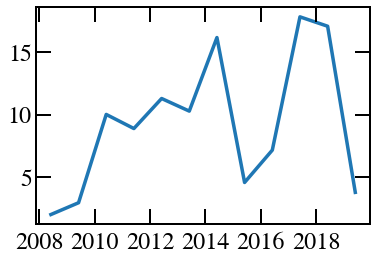

In [20]:
loc = all_years['PlayerID'] == 'duranke01'
plt.plot(all_years['Year'].loc[loc], all_years['TotalValue'].loc[loc])